# Academy Award for Best Director

We first import the packages and load the csv files into dataframes

In [0]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None

In [0]:
bestdir_url = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/best-director.csv?token=AD32IFU2AOHUJYINTWTU2N25Q2VF4'
ceremonies_url = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/ceremonies.csv?token=AD32IFUN4ABRXTMM4YAEKHK5Q2VGU'
bestdir_df = pd.read_csv(bestdir_url)
ceremonies_df = pd.read_csv(ceremonies_url)

We convert dates into datetime objects, append them as new columns. We also calculate ages using the timedeltas.

In [0]:
def get_ceremony_date(ceremonies_df, i):
  return ceremonies_df.iloc[ceremonies_df[ceremonies_df['Ceremony'] == i].index[0]]['date_dt']
def get_age(ceremonies_df, ceremony, birthdate, fmt='days'):
  if fmt == 'days':
    return (get_ceremony_date(ceremonies_df, ceremony) - birthdate).days
  elif fmt == 'ymd':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return '{}y{}m{}d'.format(rd.years, rd.months, rd.days)
  elif fmt == 'ym':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return '{}y{}m'.format(rd.years, rd.months)
  elif fmt == 'float':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return rd.years + (rd.months)/12.0 + (rd.days)/365.0

In [4]:
ceremonies_df['date_dt'] = pd.to_datetime(ceremonies_df['Date'].values, format='%B %d, %Y')
ceremonies_df['year'] = ceremonies_df.apply(lambda row: row['date_dt'].year, axis=1).copy()
bestdir_df['birthdate_dt'] = pd.to_datetime(bestdir_df['Birthdate'].values, format='%B %d, %Y')
bestdir_df['age_float'] = bestdir_df.apply(lambda row: get_age(ceremonies_df, row['Ceremony'], row['birthdate_dt'], fmt='float'), axis=1)
bestdir_df['age_ym'] = bestdir_df.apply(lambda row: get_age(ceremonies_df, row['Ceremony'], row['birthdate_dt'], fmt='ym'), axis=1)
bestdir_df.tail()

,Ceremony,Won,Film,Name,Birthdate,birthdate_dt,age_float,age_ym
448,91,False,BlacKkKlansman,Spike Lee,"March 20, 1957",1957-03-20,61.927626,61y11m
449,91,False,Cold War,Pawel Pawlikowski,"September 15, 1957",1957-09-15,61.441324,61y5m
450,91,False,The Favourite,Yorgos Lanthimos,"September 23, 1973",1973-09-23,45.419406,45y5m
451,91,True,Roma,Alfonso Cuaron,"November 28, 1961",1961-11-28,57.240639,57y2m
452,91,False,Vice,Adam McKay,"April 17, 1968",1968-04-17,50.852511,50y10m


We calculate some statistics and extract some filters which will come in handy when plotting the data.

In [0]:
female_dirs = ['Lina Wertmuller', 'Jane Campion', 'Sofia Coppola', 'Kathryn Bigelow', 'Greta Gerwig']
nominees = bestdir_df['Won'] == False
winners = bestdir_df['Won'] == True
females = bestdir_df['Name'].isin(female_dirs)
ages_per_ceremony = [bestdir_df['age_float'][bestdir_df['Ceremony']==i].values for i in range(1, len(ceremonies_df)+1)]
means = np.asarray([np.mean(x) for x in ages_per_ceremony])
medians = np.asarray([np.median(x) for x in ages_per_ceremony])
stds = np.asarray([np.std(x) for x in ages_per_ceremony])
bestdir_df['color_nw'] = bestdir_df.apply(lambda row: 'red' if row['Won'] else 'black', axis=1).copy()
bestdir_df['color_mf'] = bestdir_df.apply(lambda row: 'red' if row['Name'] in female_dirs else 'blue', axis=1).copy()
xticks_pos, xticks_lab = list(range(1, len(ceremonies_df)+1, 3)), ["'" + str(x)[-2:] for x in ceremonies_df['year'][::3].values]
hovertext = bestdir_df.apply(lambda row: '{}, {} ({}, {})'.format(row['Name'], row['age_ym'], row['Film'], 
                                                  get_ceremony_date(ceremonies_df, row['Ceremony']).year), axis=1).copy()

We plot the winners and nominees by their age at the day of the award ceremony. 

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bestdir_df['Ceremony'][nominees], y=bestdir_df['age_float'][nominees], 
                           mode='markers', marker_color=bestdir_df['color_nw'][nominees], 
                           hoverinfo="text", hovertext=hovertext[nominees], name="Nominees"))
fig.add_trace(go.Scatter(x=bestdir_df['Ceremony'][winners], y=bestdir_df['age_float'][winners], 
                         mode='markers', marker_color=bestdir_df['color_nw'][winners], 
                         hoverinfo="text", hovertext=hovertext[winners], name="Winners"))
fig.add_trace(go.Scatter(x=ceremonies_df['Ceremony'], y=medians, marker_color='green', name="Medians", hoverinfo='y', visible='legendonly'))
fig.add_trace(go.Scatter(x=ceremonies_df['Ceremony'], y=means, marker_color='blue', name="Means", hoverinfo='y', visible='legendonly'))
fig.update_layout(title='Nominees and winners through years by age')
fig.update_yaxes(zeroline=False, title='Age')
fig.update_xaxes(zeroline=False, title='Year', tickvals=xticks_pos, ticktext=xticks_lab)
fig.show()

We plot them alongside the mean and variance per each ceremony to discern some outliers in terms of age. We can also search a director by name and see how well he/she was received in Academy Awards throughout years.

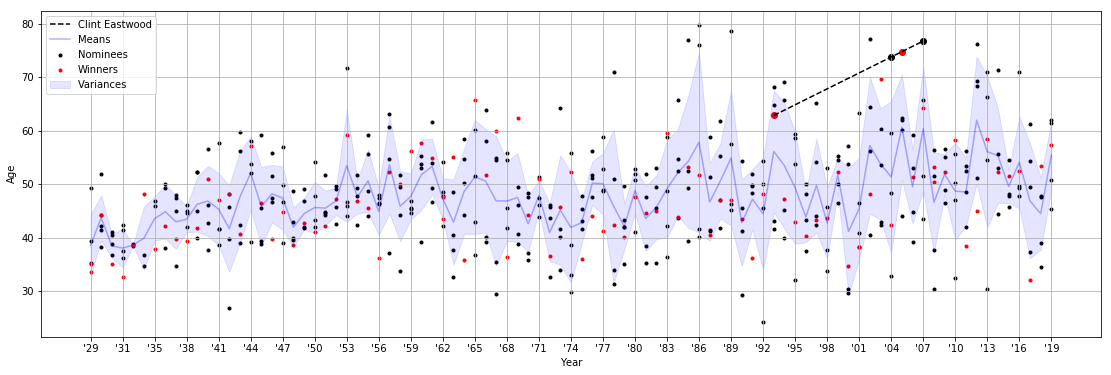

In [7]:
name = 'Clint Eastwood'
specifier = bestdir_df['Name'] == name
plt.figure(figsize=(19,6))
plt.scatter(bestdir_df['Ceremony'][nominees], bestdir_df['age_float'][nominees], marker='.', c='k', label='Nominees')
plt.scatter(bestdir_df['Ceremony'][winners], bestdir_df['age_float'][winners], marker='.', c='r', label='Winners')
plt.plot(bestdir_df['Ceremony'][specifier], bestdir_df['age_float'][specifier], linestyle='--', c='k', label=name)
plt.scatter(bestdir_df['Ceremony'][nominees & specifier], bestdir_df['age_float'][nominees & specifier], c='k', label='_nolegend_')
plt.scatter(bestdir_df['Ceremony'][winners & specifier], bestdir_df['age_float'][winners & specifier], c='r', label='_nolegend_')
plt.plot(ceremonies_df['Ceremony'], means, linestyle='-', c='b', alpha=0.3, label='Means')
# plt.plot(ceremonies_df['Ceremony'], medians, linestyle='-', c='g', alpha=0.7, label='Medians')
plt.fill_between(ceremonies_df['Ceremony'], means-stds, means+stds, color='b', alpha=0.1, label='Variances')
plt.xticks(xticks_pos, xticks_lab)
plt.grid(True)
plt.ylabel('Age')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()